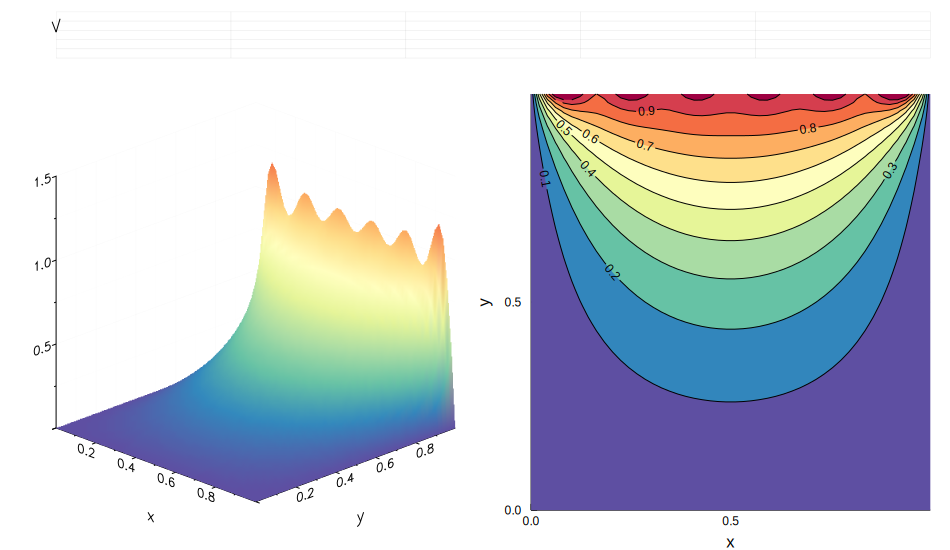

In [2]:
srf_plot(analytic(11), zlm=(0,Inf))

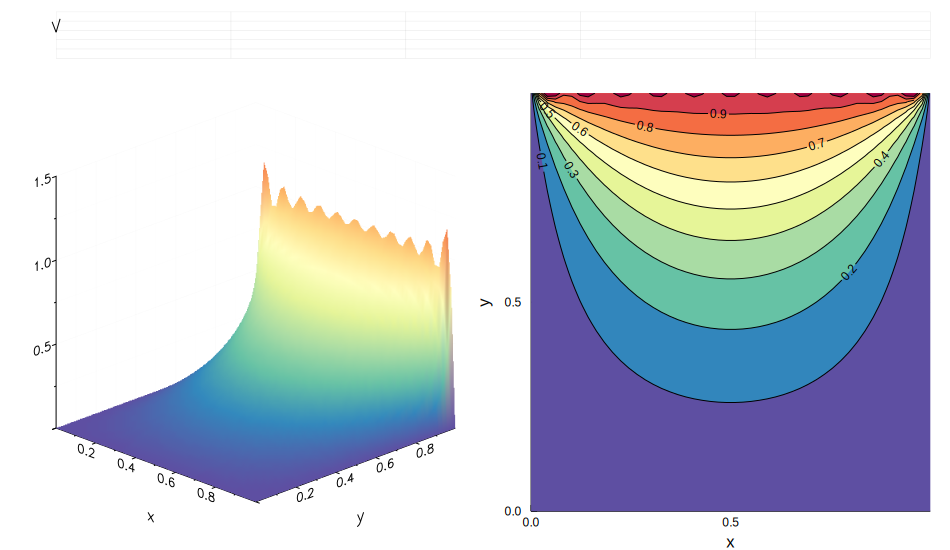

In [3]:
srf_plot(analytic(21), zlm=(0,Inf))

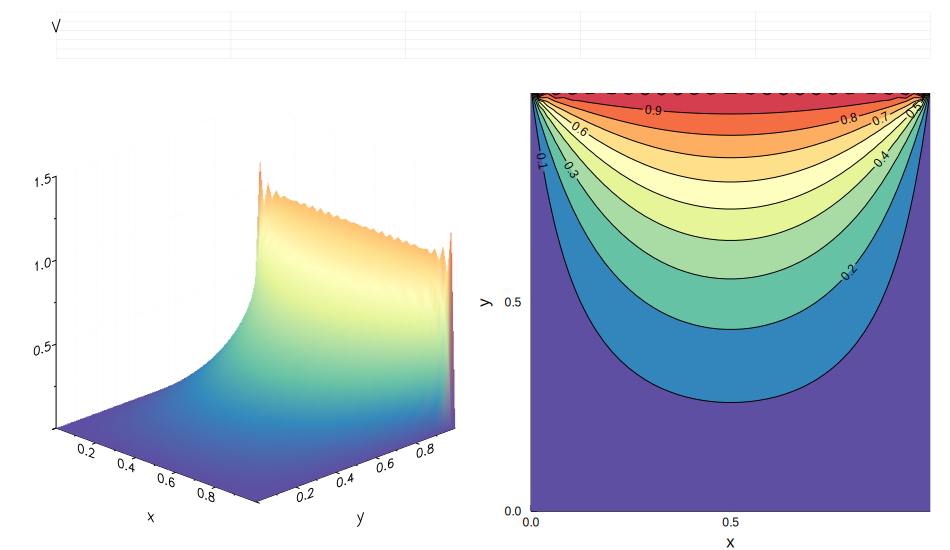

In [4]:
srf_plot(analytic(51), zlm=(0,Inf))

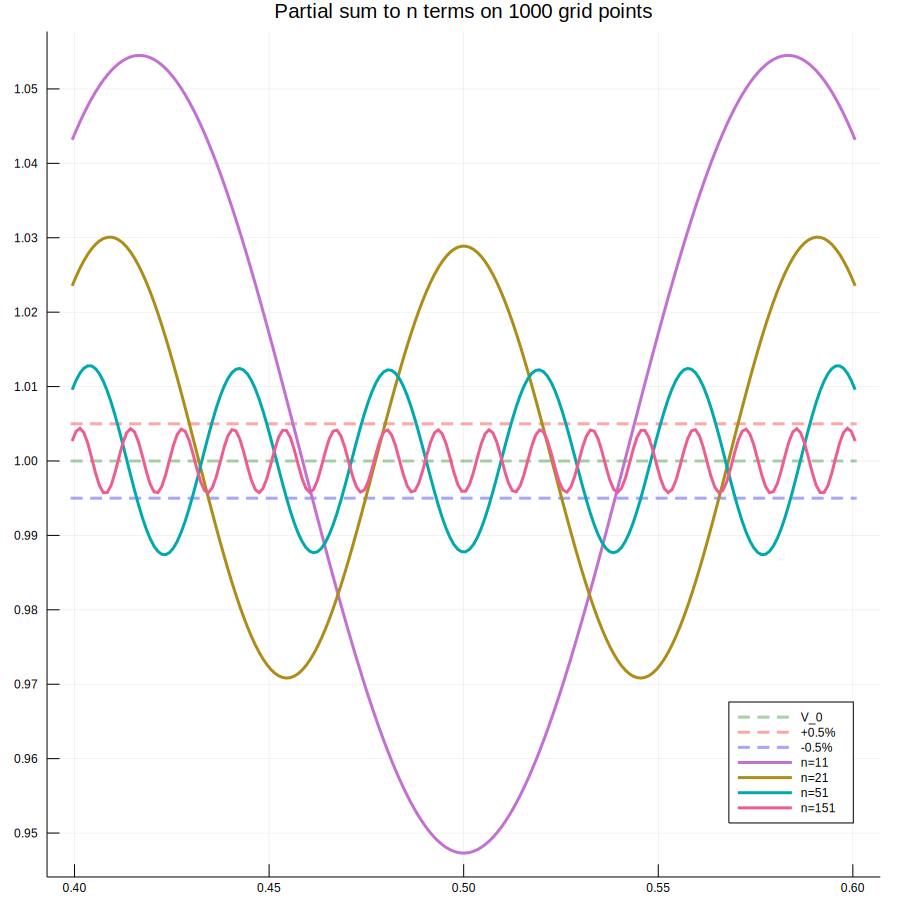

In [5]:
one_percent()

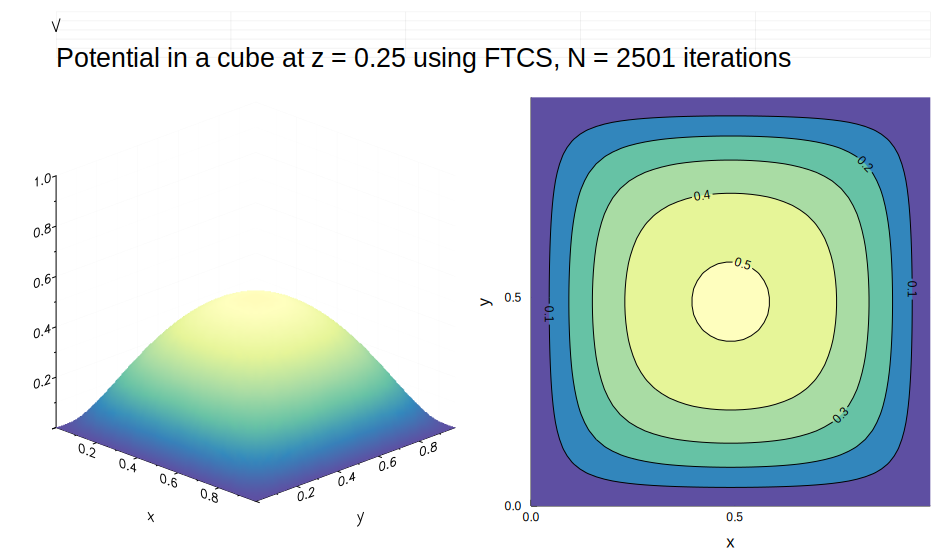

In [6]:
vol_plot(laplace(mthd=ftcs), lvl=0.25)

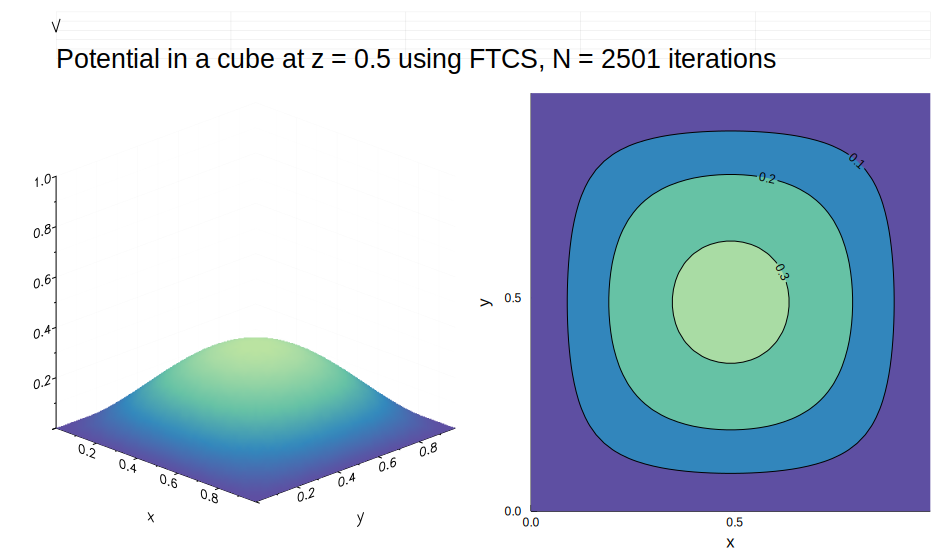

In [7]:
vol_plot(laplace(mthd=ftcs), lvl=0.5)

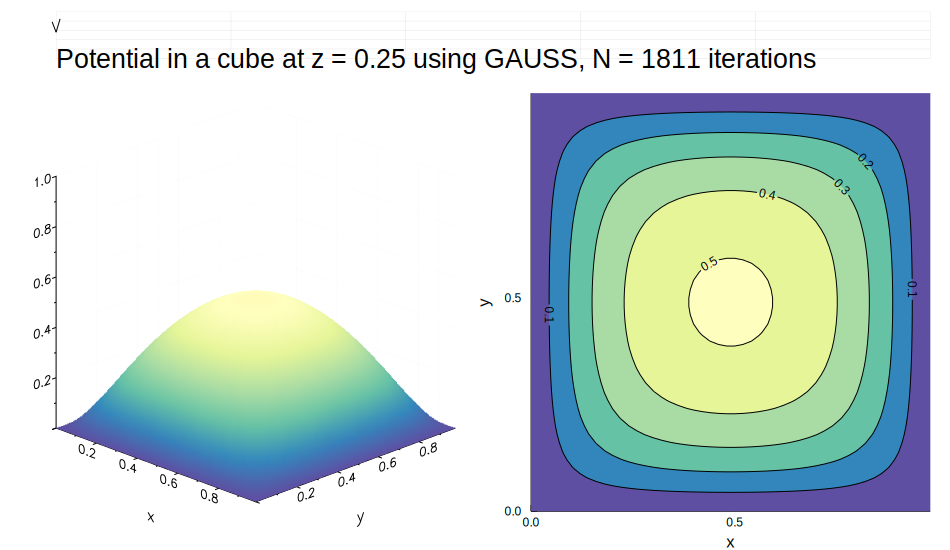

In [8]:
vol_plot(laplace(mthd=gauss), lvl=0.25)

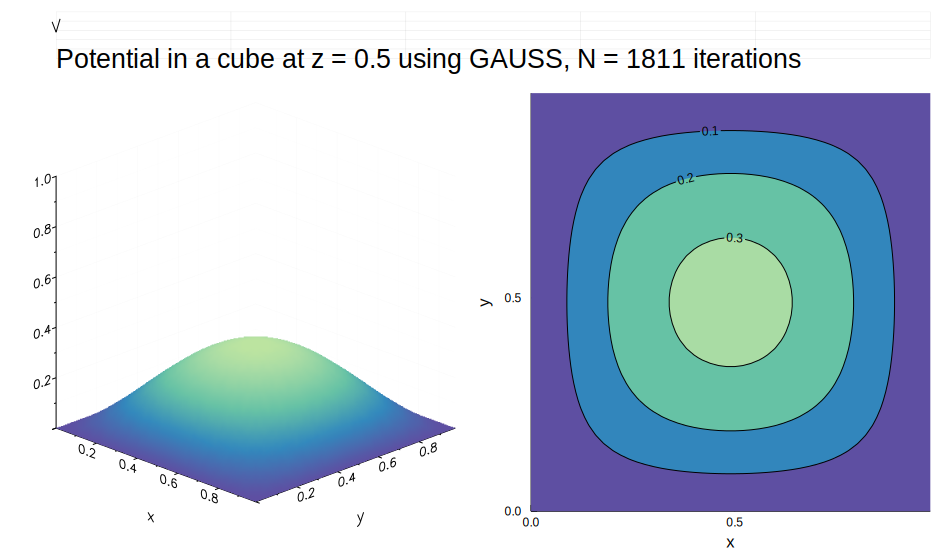

In [9]:
vol_plot(laplace(mthd=gauss), lvl=0.5)

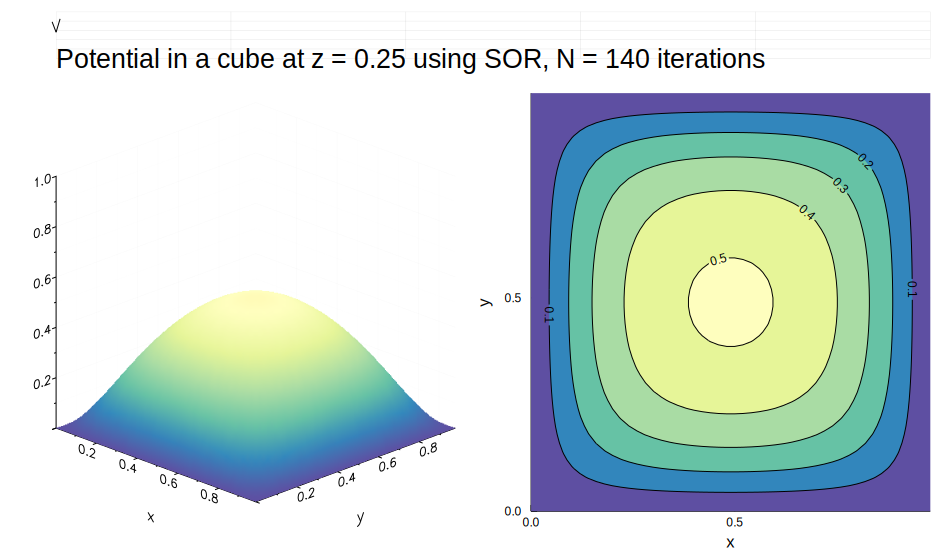

In [10]:
vol_plot(laplace(mthd=sor), lvl=0.25)

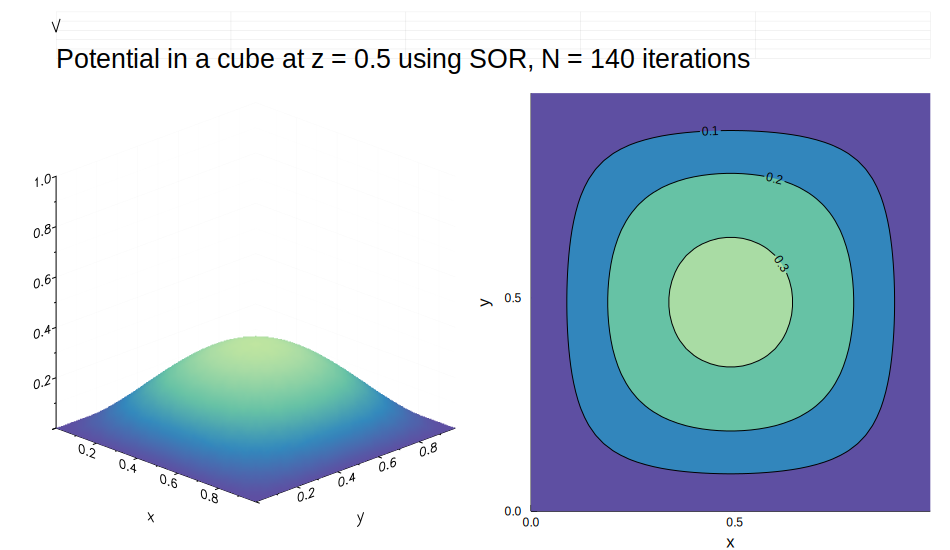

In [11]:
vol_plot(laplace(mthd=sor), lvl=0.5)

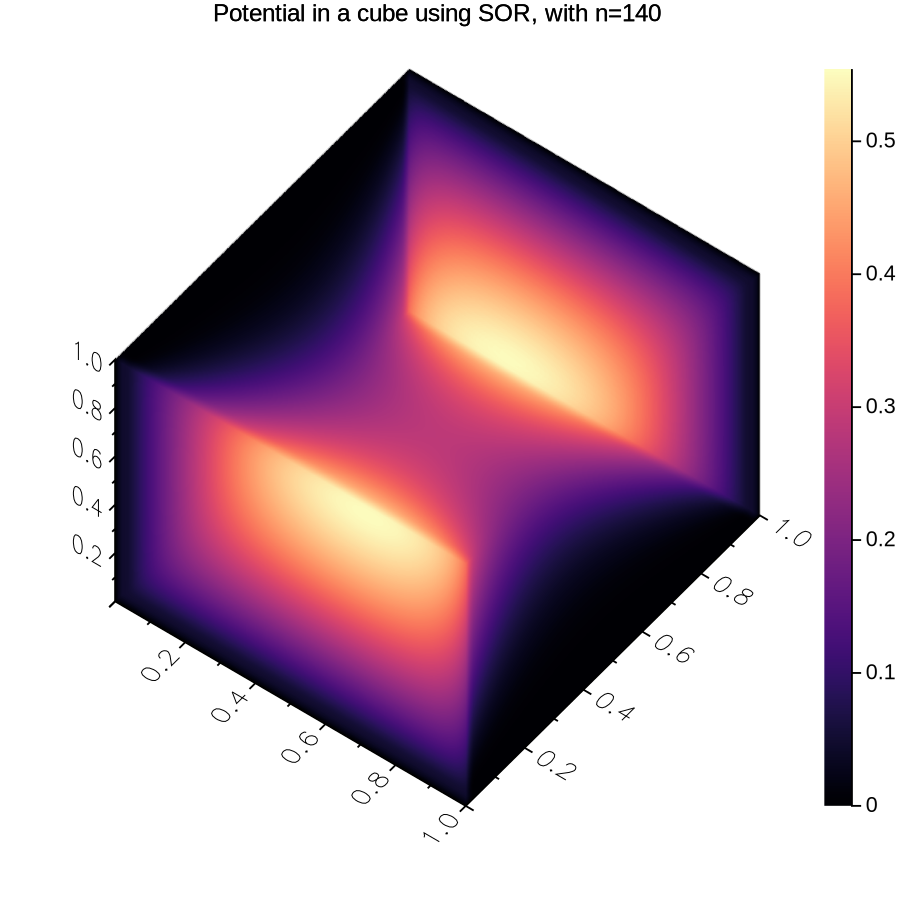

In [24]:
mip(mthd=sor)

In [23]:
using Plots
import GR
gr()

#——————————————————————————————————————————————————————————————————————————————————————————————————————————————————————#
# Main programs

function analytic(n; gp=50, V=1., Lx=1., Ly=1.)
    hx = Lx/(gp-1)
    hy = Ly/(gp-1)
    
    srf = zeros(gp, gp)
    for i in 1:gp
        srf[i,:] = [(V*4/pi)*sum((sin(k*pi*(j-1)*hx/Lx)*sinh(k*pi*(i-1)*hy/Lx))/(k*sinh(k*pi*Ly/Lx))
                        for k in 1:2:n) for j in 1:gp]
    end
    
    return (srf, [x*hx for x in 0:(gp-1)], [y*hy for y in 0:(gp-1)])
end

# Calculate Laplace equation in a cube. mthd = integrator, gp = grid points, int = interior values (random or zeros)
function laplace(; mthd, gp=50, V=1., L=1., intr=zeroint)
    h = L/gp
    
    # Initialize our cube with points defined by an intr function. Defaults to all zeros.
    vol = intr(gp)
    
    # Boundary conditions:
    # V(0,y,z) = V(L,y,z) = 0
    # V(x,0,z) = V(x,L,z) = 0
    # V(x,y,0) = V(x,y,L) = V0
    vol[:, :, 1] .= V
    vol[:, :, end] .= V
    
    xx = [x*h for x in 0:(gp-1)]
    yy = [y*h for y in 0:(gp-1)]
    zz = [z*h for z in 0:(gp-1)]
    
    v, imax = mthd(vol)
    return (v, xx, yy, zz, uppercase(string(mthd)), imax)
end

zeroint(gp) = zeros(gp,gp,gp)
function randint(gp)
    vol = rand(gp,gp,gp)
    for z in 2:(gp-1)
        vol[1,:,z] .= 0.
        vol[:,1,z] .= 0.
        vol[end,:,z] .= 0.
        vol[:,end,z] .= 0.
    end
end

#——————————————————————————————————————————————————————————————————————————————————————————————————————————————————————#
# Integrators

function ftcs(v)
    gp = size(v,1)
    div = (gp-2)^2
    imax = 0
    c = copy(v)
    
    for iter in 1:gp^2
        c_sum = 0
            
        for k in 2:(gp-1)
            for i in 2:(gp-1)
                for j in 2:(gp-1)
                    c[i,j,k] = 1/6*(v[i+1,j,k] + v[i-1,j,k] + 
                                    v[i,j+1,k] + v[i,j-1,k] + 
                                    v[i,j,k-1] + v[i,j,k+1])
                    
                    c_sum += abs(1-v[i,j,k]/c[i,j,k])
                end
            end
        end
        
        v = copy(c)
        imax = iter
       
        if c_sum/div < 1e-4
            break
        end
    end
    return (v,imax)
end

function gauss(v)
    gp = size(v,1)
    div = (gp-2)^2
    imax = 0
    
    for iter in 1:gp^2
        c_sum = 0
    
        for k in 2:(gp-1)
            for i in 2:(gp-1)
                for j in 2:(gp-1)
                    temp = 1/6*(v[i+1,j,k] + v[i-1,j,k] + 
                                v[i,j+1,k] + v[i,j-1,k] + 
                                v[i,j,k-1] + v[i,j,k+1])
                    
                    c_sum += abs(1-v[i,j,k]/temp)
                    v[i,j,k] = temp
                end
            end
        end
        
        imax = iter
        if c_sum/div < 1e-4
            break
        end
    end
    
    return (v,imax)
end

function sor(v)
    gp = size(v,1)
    w = 2/(1+sin(pi/gp))
    div = (gp-2)^2
    imax = 0
    
    for iter in 1:gp^2
        c_sum = 0
        
        for k in 2:(gp-1)
            for i in 2:(gp-1)
                for j in 2:(gp-1)
                    temp = w/6*(v[i+1,j,k] + v[i-1,j,k] + 
                                v[i,j+1,k] + v[i,j-1,k] + 
                                v[i,j,k-1] + v[i,j,k+1]) + (1-w)*v[i,j,k]
                    
                    c_sum += abs(1-v[i,j,k]/temp)
                    v[i,j,k] = temp
                end
            end
        end
        
        imax = iter
        if c_sum/div < 1e-4
            break
        end
    end
    
    return (v,imax)
end

#——————————————————————————————————————————————————————————————————————————————————————————————————————————————————————#
# Plotting

function srf_plot(dat; ttl="", zlm=(0.,1.))
    zz, xx, yy = dat
    l = @layout [a{0.1h} ; b{0.5w} c{0.5w}]
        
    srf=surface(xx, yy, zz,
                xlabel=:"x", ylabel=:"y", zlabel=:"V(x,y)",
                xticks=0:0.5:1., yticks=0:0.5:1.,
                zlims=zlm,
                color=:Spectral_r, colorbar=false,
                st=:surface, camera=(45,45))

    con=contour(xx, yy, zz,
                xlabel=:"x", ylabel=:"y", 
                xticks=0:0.5:1., yticks=0:0.5:1.,
                levels=[i for i in 0.:0.1:1.],
                color=:Spectral_r, colorbar=false,
                st=:contourf, contour_labels=true)
    
    pt=plot(annotation = (0, 0, text(ttl, 18, :left)), showaxis=:false, showgrid=:false)

    plot(pt, srf, con, layout=l, size=(950,550))
end

function vol_plot(dat; lvl)
    vol, xx, yy, zslices, mthd, imax = dat
    gp = size(vol,3)
    zz = vol[:,:,Int(round(gp*lvl)+1)]
    zi = round(zslices[Int(round(gp*lvl)+1)], digits=2)
    ttl = "Potential in a cube at z = $(lvl) using $(mthd), N = $(imax+1) iterations"
    srf_plot((zz,xx,yy), ttl=ttl)
end

function vol_gif(dat)
    vol, xx, yy, zslices, mthd, imax = dat

    anim = @animate for i in 2:(size(vol,1)-1)
        zz = vol[:,:,i]
        zi = "$(round(zslices[i], digits=2))"
        if length(zi) < 5
            zi = rpad(zi, 5, "0")
        end
        
        ttl = "Potential in a cube at z = $(zi); $(mthd) method, $(imax+1) iterations"
        srf_plot((zz,xx,yy),ttl=ttl)
    end every 1
    
    gif(anim, string("laplace_", mthd, ".gif"))
end

function one_percent()
    nums=[11, 21, 51, 151]
    gp = 1000
    lft = Int(round(gp*0.4))
    rt = gp-lft+1
    
    hz = [i/gp for i in (lft-1):rt]
    v0 = [1. for i in (lft-1):rt]
    vp = [1.005 for i in (lft-1):rt]
    vm = [0.995 for i in (lft-1):rt]

    p = plot(title="Partial sum to n terms on $gp grid points",
             size=(900,900), yticks=0.9:0.01:1.1, legend=:bottomright)
    
    plot!(hz, v0, l=(3,:dash,:green), alpha=0.35, label="V_0")
    plot!(hz, vp, l=(3,:dash,:red), alpha=0.35, label="+0.5%")
    plot!(hz, vm, l=(3,:dash,:blue), alpha=0.35, label="-0.5%")

    for n in nums
        dat = analytic(n, gp=1000)
        srf, xx, yy = dat
        plot!(p, xx[lft:rt], srf[end, lft:rt], lw=3, label="n=$n")
    end

    p
end

# Maximum intensity projection suggested by Anshul Singhvi on Julia's Slack server.
function mip(; mthd, gp=50)
    v = zeros(gp, gp, gp)
    v[:,:,1] .= 1.
    v[:,:,end] .= 1.

    pv, numiter = mthd(v) # plot volume

    GR.title("Potential in a cube using $(uppercase(string(mthd))), with n=$(numiter+1)")
    GR.volume(pv, algorithm = 0, colormap = 47, size=(900,900))
end;

In [15]:
# vol_gif(laplace(mthd=ftcs, gp=100));

In [16]:
# vol_gif(laplace(mthd=gauss, gp=100));

In [17]:
# vol_gif(laplace(mthd=sor, gp=100));